In [1]:
## Notebook env: brian_script_env (R kernel)

In [2]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(tidyverse)


path2 = '/khayyam/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original_tnbc/'


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.4.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [3]:
## load patient metadata
meta = read.csv('/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_bcr_clinical_data_patient.txt', skip = 4, sep='\t')

## classify patients into subtypes
meta_luminal_A = meta %>% filter(ER_STATUS_BY_IHC == 'Positive' | PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Negative')
meta_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Positive')
meta_tnbc = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Negative')
meta_luminal_B_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Positive', PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Positive')

meta_luminal_A$PATIENT_ID = paste0(str_replace_all(meta_luminal_A$PATIENT_ID, '-', '.'), '.01')
meta_her2$PATIENT_ID = paste0(str_replace_all(meta_her2$PATIENT_ID, '-', '.'), '.01')
meta_tnbc$PATIENT_ID = paste0(str_replace_all(meta_tnbc$PATIENT_ID, '-', '.'), '.01')
meta_luminal_B_her2$PATIENT_ID = paste0(str_replace_all(meta_luminal_B_her2$PATIENT_ID, '-', '.'), '.01')

## Get patient subtype counts
paste('Luminal A patients:', nrow(meta_luminal_A))
paste('HER2+ patients:', nrow(meta_her2))
paste('Triple negative patients:', nrow(meta_tnbc))
paste('Luminal B with HER2+ patients:', nrow(meta_luminal_B_her2))

[1] "Luminal A patients: 445"

[1] "HER2+ patients: 37"

[1] "Triple negative patients: 116"

[1] "Luminal B with HER2+ patients: 100"

[1] FALSE

png 
  2

png 
  2

[1] 73.16453

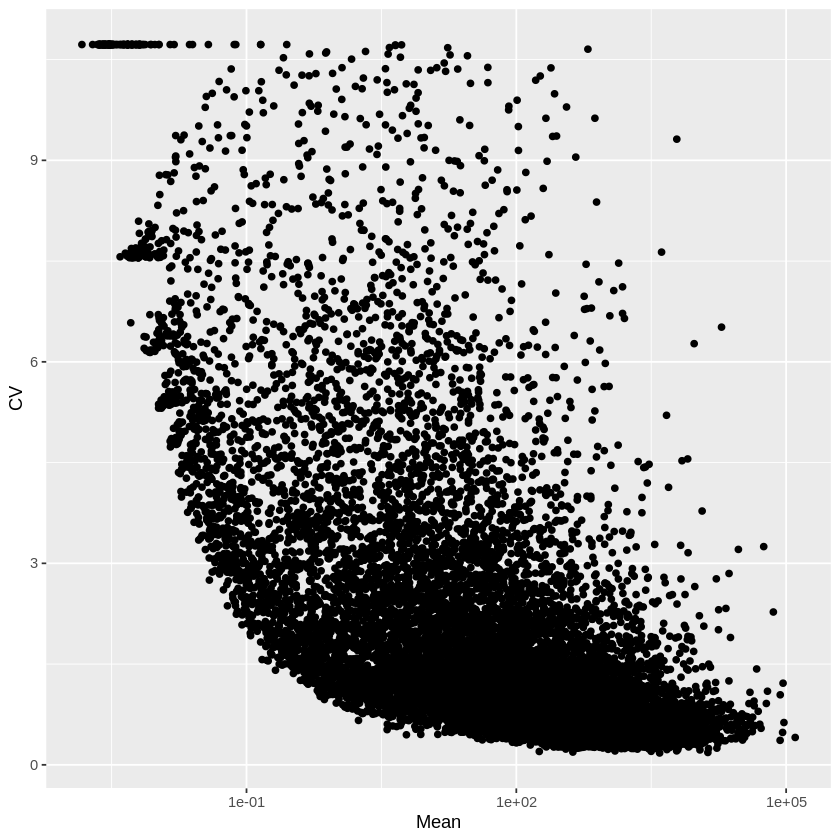

In [4]:
#' ---
#' title: "Analyzing BRCA TCGA data, FPKM data of **medium to high expressing** genes using Brian's script"
#' output: html_notebook
#' ---
#' 
#' This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#' 
#' Let's create a mean vs CV graph for the patients to create a remove low expressing genes with high variability from our analysis
#' 
## ------------------------------------------------------------------------------



## load in data
RNA_Seq_expression_raw_data <- 
read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## subset breast cancer patients by type here
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_tnbc$PATIENT_ID))) %>% as.data.frame()

#The 'all' approach to check if all values in a row are 0
check_if_not_zero <- function (vector, number = 0) {
  if (!(all (vector == number))) {
    return (TRUE) #if not zero, then returns TRUE
  }
  else{
    return(FALSE)
  }
}

#See if there are any rows that are FALSE, meaning that are actually all 0
all(as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))) 
zero_genes = as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))

##take out genes with no expression in any of the patients
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data[as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero))),]


gene_medians = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, median)

median_df = data.frame(medians = gene_medians)

pdf(paste0(path2, 'gene_expression_pre_filter1.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 500) +
  geom_vline(xintercept = 10, color = 'blue') +
  theme_bw()
dev.off()

pdf(paste0(path2, 'gene_expression_pre_filter2.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,200)) +
  theme_bw()
dev.off()


pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(gene_medians, 10)

gene_means = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, mean)
gene_CVs = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, function(x){sd(x)/mean(x)})


gene_level_df = data.frame(Gene_name = RNA_Seq_expression_raw_data$Hugo_Symbol, Mean = gene_means, CV = gene_CVs)

ggplot(gene_level_df, aes(Mean, CV)) + geom_point() + scale_x_log10(breaks = log_breaks(5))


[1] 914

[1] 2463

[1] 577

[1] TRUE

[1] TRUE

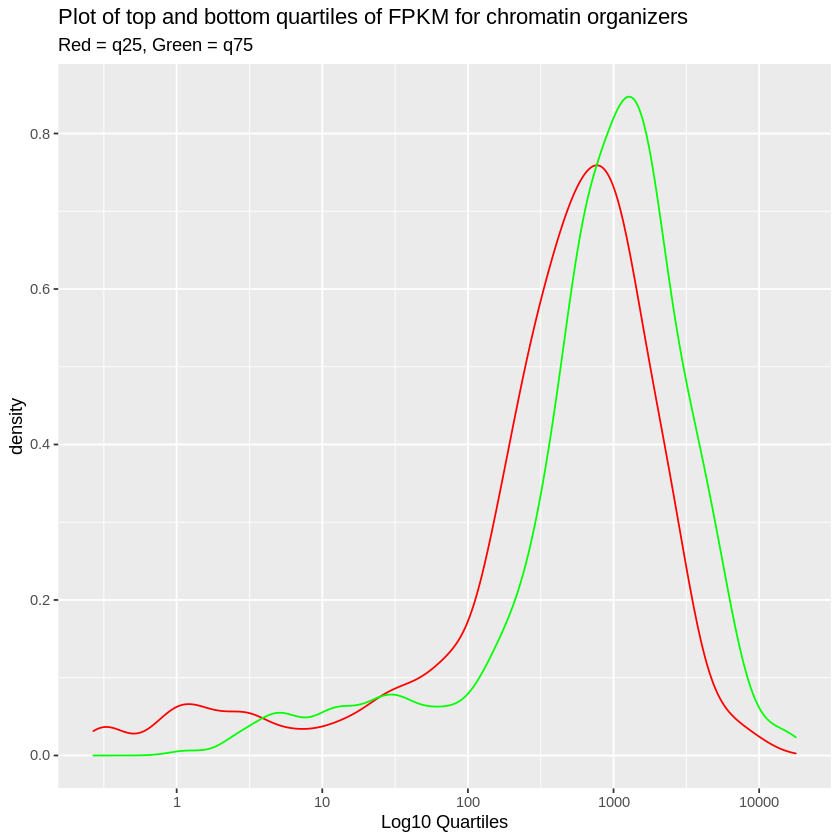

In [5]:
#' Copy and paste Brian's analysis from this point on
## ---- Data loading-------------------------------------------------------------

#Load in chromatin organization modifiers. How this was found: GO term, eukaryota => #mammalia => homo sapiens. Gives a list of gene products; there's non-unique entries #(contributed by different sources, etc)

chromatin_modifiers <- read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/Chromatin_modifiers.txt", header=FALSE, stringsAsFactors=FALSE)

#the first column is the one of interest
colnames(chromatin_modifiers)[1] <- 'Gene Names'

chrom_list_to_sort_against <- unique(chromatin_modifiers$`Gene Names`)

#check lengths of new and original list from chromatin modifiers

length(chrom_list_to_sort_against) 
length(chromatin_modifiers$`Gene Names`)

#logic to extract the chromatin modifier genes specifically from the full RNA Seq list.
#Use the %in% operator to (vector-wise) get the rows specifically. Use this to get
#the quartiles for each gene:

set.seed(42)

chromatin_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% chrom_list_to_sort_against,]

#And these are the 'true' groupings. Let's add a column to denote that here, in front
#of the first two columns using the 'add_column' function from tibble library:

chromatin_genes_RNA_seq <- add_column(chromatin_genes_RNA_seq,
                                      Random = 'N', .after = 2)

length(rownames(chromatin_genes_RNA_seq))

#We'd like to also derive a background distribution for all of these genes. To do so,
#let's append 50 genes that are randomly selected from the dataset, and their #corresponding rows. 

random_genes <- sample(RNA_Seq_expression_raw_data$Hugo_Symbol, 50)
random_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% random_genes,]

random_names <- random_genes_RNA_seq$Hugo_Symbol

#Let's also add an equivalently named column here to denote that these are the random genes: 

random_genes_RNA_seq <- add_column(random_genes_RNA_seq, Random = 'Y', .after = 2)

full_genes_RNA_seq <- rbind(chromatin_genes_RNA_seq, random_genes_RNA_seq)

length(rownames(full_genes_RNA_seq)) == 
length(rownames(chromatin_genes_RNA_seq)) + length(rownames(random_genes_RNA_seq)) #TRUE

#creating a threshold with which to create 'hi' vs 'lo' populations of patients; here, I #choose to use top vs bottom quartile. Need to apply quantile across the rows of the #chromatin_genes data frame, excluding the first observation (which is a character string #of the gene name in question)

q25 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.25), na.rm = TRUE)

q75 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.75), na.rm = TRUE)


full_genes_RNA_seq <- add_column(full_genes_RNA_seq, q25 = q25, q75 = q75, .after = 3)

all (full_genes_RNA_seq$q25 <= full_genes_RNA_seq$q75) #true

#Also remove data where the bottom quartile is 0 FPKM. This doesn't seem like it would
#provide any meaningful data to a CV comparison.

full_genes_RNA_seq <- 
full_genes_RNA_seq[!(full_genes_RNA_seq$q25 == 0),]

#Viewing the data and indices

ggplot(full_genes_RNA_seq) + geom_density(aes (x = q25), color = 'red') +
geom_density (aes (x = q75), color = 'green') + 
labs (title = 'Plot of top and bottom quartiles of FPKM for chromatin organizers', 
      subtitle = 'Red = q25, Green = q75',
      x = 'Log10 Quartiles') + 
scale_x_log10()

In [6]:
#' ### Getting groupings of the data based on chromatin modifier expression
#' 
#' We've now completed some EDA of the data and cleaning of useless chromatin modifier factors that wouldn't be good for grouping. Now, let's get dataframes corresponding to these groupings in a list format to each unique chromatin modifier, then use these groupings to get subsetted dataframes from the full dataset corresponding to bottom/top expressers of each chromatin modifier.
#' 
## ---- Getting lo/hi groupings--------------------------------------------------

#Now I want lo and hi expressers (below q25, above q75) for each gene. Way to approach #this: create different groupings, based on hi/lo threshold. To first get the groupings #and return #them in a list: define a function that returns up to three entries in list #format. These are: Gene name, all names below the bottom quantile, and all names above #the top quantile.

groupings_returner <- function (gene, chromatin_data, gene_col = 1, random = 3, 
                                q25_col = 4, q75_col = 5) {
  #the q25_col, q75_col are last two columns in the data frame
  q25 = chromatin_data[chromatin_data[,gene_col]==gene, q25_col] 
  q75 = chromatin_data[chromatin_data[,gene_col]==gene, q75_col]
  rand_designation = chromatin_data[chromatin_data[,gene_col]==gene, random] 
  #get the q25, q75 'indices'
  row = chromatin_data[chromatin_data[,gene_col]==gene, c(-1:-2, -random, 
                                                          -q25_col, -q75_col)]
  #eliminate gene ID, the q25 and q75 columns; isolate a single row
  col = data.frame(t(row)) 
  #get into column format for easy use of row subsetting techniques
  colnames(col) = 'expression_levels'
  list_below_25 = rownames(col[col$expression_levels <= q25,, drop= FALSE]) 
  #to keep row names
  list_above_75 = rownames(col[col$expression_levels >= q75,, drop= FALSE])
  return (list(gene, rand_designation, list_below_25, list_above_75)) 
  #list of 3 entries. First = gene, second = bottom quartile, third = top quartile
}

#let's test that this function works as intended: make a 'test' vector that corresponds 
#to the ACTB gene, then compare this to the corresponding list in the full list.
#Note that the 1103 and 1104 columns correspond to the q25, q75 columns correspondingly.

test <- groupings_returner('HDAC2', full_genes_RNA_seq)

str(test) #should look like a 4 item list

#Some warnings will occur: this is because I sampled 50 randomly from the full dataset.
#Some overlapped with the list of chromatin modifiers list. This seems reasonable to 
#keep though.

groupings <- lapply(full_genes_RNA_seq$Hugo_Symbol, groupings_returner,                                       full_genes_RNA_seq)
str(groupings)

groupings[[2]][2] %in% test[3] #false

groupings[[1]][2] %in% test[2] #TRUE

#should have list of length equal to the chromatin gene list, with two or three entries #in each entry of the list

length(groupings) == length(full_genes_RNA_seq$Hugo_Symbol) 

#Now, using this list of groupings, I should then create dataframes corresponding to each
#groupings list, i.e. for below bottom quantile and above top quantile. This function #should take in a 'key' (each LIST entry within the groupings list) and return either #nothing, or two dataframes.

dataframe_returner <- function (key, full_data, additional_col_vectors = c(),
                                key_gene_entry = 1, key_random_entry = 2, 
                                key_25_entry = 3, key_75_entry = 4) {
    #additional_col_vectors fetches columns by name
  
    #Idea is to aggr. the columns that correspond to the 'correct' patients for each
    #quartile grouping
    q25_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_25_entry]])]
    #key_2/75_entry is a numeric index
    q75_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_75_entry]])]
    return (list(key[[key_gene_entry]], key[[key_random_entry]],
                 q25_dataframe, q75_dataframe))
}

#As a test: try this with the first gene entry from the above groupings data structure. #Expect: a three-entry list, with the first entry being the gene name, the second and #third being the corresponding data frames. Should have a dataframe with gene IDs, #followed by expression levels.

#use names in this vector to fetch columns corresponding to these two names
gene_vec <- c('Hugo_Symbol', 'Entrez_Gene_Id') 

#check that this list looks correct for a random gene, ACTL6A, index 1)
str(dataframe_returner(groupings[[1]], RNA_Seq_expression_raw_data, gene_vec)) 

#Code to actually get the grouped data
grouped_dataframes_list <- lapply(groupings, dataframe_returner, 
                                  RNA_Seq_expression_raw_data, gene_vec)

#' 
#' ### Appending CVs, CV ratios, to the grouped dataframe object
#' 
#' Let's now calculate CVs and the corresponding CV ratios for each gene between the bottom 
#' and top quartile groups. We will append these to the current grouped dataframes list object made in the previous code chunk. These will be used to determine whether a gene 
#' went up or down in its CV between lower and higher expression of the chromatin modifier in question.
#' 
## ---- Appending CVs------------------------------------------------------------
#First define a coefficient of variation function and apply across each row of the #dataframes in the grouped list:

coeff_variation <- function (vector) {
  return (sd(vector)/abs(mean(vector)))
}

#Calculate coefficient of variation for the entire grouped dataframes list.
#First define a helper function that takes in a list, and applies the given 
#function to the specified entries of the list (here, would like these entries to be the
#second and third entries). It then adds a new column corresponding to the values it 
#calculated. 

#omit the two first cols from being within the coeff_var calc, as they correspond to the #name/Gene ID for the gene in question

indices_omit <- -1:-2 

#This function operates at the level of a single dataframe. It takes in a dataframe and 
#returns a modified dataframe that has CV appended to the dataframe as a column. 

col_adjuster <- function (entry, omitted_indices = indices_omit, row_or_col = 1,
                          column_to_add_after = 2, col_name = 'CV',
                          f = coeff_variation, ...) {
  if (is.data.frame(entry)) {
    #has this is.data.frame entry so I can just simply apply this function across 
    #all of the list entries in the df_list that contain either df's or strings
      "... refers to the arguments of 'f'"
      col_result <- apply(entry[, omitted_indices], row_or_col, f, ...)
      #print(CV)
      entry <- add_column (entry, name = col_result, .after = column_to_add_after)
      colnames(entry)[colnames (entry) == 'name'] <- col_name 
      #adds the CV col (result of applying the function f) to original entry dataframe,
      #reassigning the name to match the name of the (statistic) calculated, e.g. CV, etc
  return (entry)
 #return the modified entry
  } else {
    return (entry)
  }
}

#Double apply call: nested lapply call works at the single list of dataframe level, 
#and the outer lapply call works to apply this across the entire grouped_dataframes_list
#object

grouped_dataframes_list_with_CV <- pblapply(grouped_dataframes_list, function (list) {
  lapply (list, col_adjuster) })

#Check that manually calculating CV gives the same result as this above call:

test_CV <- coeff_variation(as.numeric(grouped_dataframes_list[[2]][[3]][2,-1:-2]))

CV_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][2,]$CV

CV_not_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][50,]$CV

test_CV == CV_to_match #TRUE

test_CV == CV_not_to_match #FALSE
                                
#Now, take the ratios of the CV values. After doing this, then will have e.g. ~20440 #ratios. This function below works at the level of a 3-entry list, with one specified #entry in the list being a dataframe corresponding to bottom quantile, and vice versa for #top quantile.

CV_divider <- function (list, CV_index = 3, q25_entry = 3, q75_entry = 4) {
  #Calculate the CV ratio between q25 and q75 by dividing the two respective cols
  CV_ratio <- list[[q25_entry]][, CV_index]/list[[q75_entry]][, CV_index]
  
  list[[q25_entry]] <- add_column(list[[q25_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  #adds a CV_ratio column to the bottom quantile dataframe in the list
  list[[q75_entry]] <- add_column(list[[q75_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  return (list)
}

#See if this function works for just one entry in the full dataframe list (i.e. a 3-
#entry list)

test_CV_ratio <- CV_divider(grouped_dataframes_list_with_CV[[2]])

test_CV_ratio[[3]]$CV_ratio #should exist

grouped_dataframes_list_with_CV_ratio <- lapply(grouped_dataframes_list_with_CV, 
                                                CV_divider)

#Remove rows with NaN: define a function that removes all rows that are NaN for the 
#specified CV_ratio column (here, the 4th index). This meant that all of the rows
#were 0 for either the q25 grouping or q75 grouping, not unexpected (many genes 
#had high levels of 0's in the full dataset).

#!!Huge memory sink!! NEED TO FIX THIS. MEMORY VIRTUAL EXHAUSTED

#options (future.globals.maxSize = 4000 * 1024^5)

NaN_omitter <- function (entry, CV_ratio_col = 4) {
  if (is.data.frame(entry)) {
    return (entry[is.finite (entry[, CV_ratio_col]) ,])
  } else {
    return (entry)
  }
}

lapply_wrapper <- function (df_list, f) {
  return (lapply(df_list, f))
}

grouped_dataframes_list_with_CV_ratio_cleaned <- pblapply(grouped_dataframes_list_with_CV_ratio, lapply_wrapper, NaN_omitter)

#check that names match:
names_list <- lapply(grouped_dataframes_list, function (list) list[[1]])

names_CV_ratio <- lapply(grouped_dataframes_list_with_CV_ratio, function (list) 
  list[[1]])

names_CV_clean <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) 
  list[[1]])

identical(names_list, names_CV_ratio)

identical(names_list, names_CV_clean)

save(grouped_dataframes_list_with_CV_ratio_cleaned, file = paste0(path2, 'gped_clean_df_CV_ratio_q10_q90.RData'))

List of 4
 $ : chr "HDAC2"
 $ : chr "N"
 $ : chr [1:29] "TCGA.A2.A1G6.01" "TCGA.A7.A0DA.01" "TCGA.AC.A2QJ.01" "TCGA.AN.A0AL.01" ...
 $ : chr [1:29] "TCGA.A1.A0SK.01" "TCGA.A1.A0SP.01" "TCGA.A2.A0CM.01" "TCGA.A2.A0T0.01" ...


Warning message in col$expression_levels <= q25:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels >= q75:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels <= q25:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels >= q75:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels <= q25:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels >= q75:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels <= q25:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels >= q75:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels <= q25:
“longer object length is not a 

List of 566
 $ :List of 4
  ..$ : chr "ACTL6A"
  ..$ : chr "N"
  ..$ : chr [1:29] "TCGA.A2.A1G6.01" "TCGA.A2.A3XX.01" "TCGA.A7.A0DA.01" "TCGA.A7.A6VY.01" ...
  ..$ : chr [1:29] "TCGA.A1.A0SK.01" "TCGA.A1.A0SP.01" "TCGA.A2.A0CM.01" "TCGA.A2.A0D0.01" ...
 $ :List of 4
  ..$ : chr "ACTR5"
  ..$ : chr "N"
  ..$ : chr [1:29] "TCGA.A7.A0DA.01" "TCGA.A7.A6VW.01" "TCGA.A8.A07C.01" "TCGA.A8.A08R.01" ...
  ..$ : chr [1:29] "TCGA.A2.A04U.01" "TCGA.A2.A0CM.01" "TCGA.A2.A0D0.01" "TCGA.A2.A3XT.01" ...
 $ :List of 4
  ..$ : chr "ACTR6"
  ..$ : chr "N"
  ..$ : chr [1:29] "TCGA.A2.A0T0.01" "TCGA.A2.A0YE.01" "TCGA.A2.A3XY.01" "TCGA.A7.A4SE.01" ...
  ..$ : chr [1:29] "TCGA.A1.A0SK.01" "TCGA.A2.A0D2.01" "TCGA.A2.A3XT.01" "TCGA.A2.A3XX.01" ...
 $ :List of 4
  ..$ : chr "ACTR8"
  ..$ : chr "N"
  ..$ : chr [1:29] "TCGA.A2.A04U.01" "TCGA.A2.A0D0.01" "TCGA.A2.A0D2.01" "TCGA.A2.A0T2.01" ...
  ..$ : chr [1:29] "TCGA.A2.A0T0.01" "TCGA.A2.A0YE.01" "TCGA.A2.A1G6.01" "TCGA.A7.A26G.01" ...
 $ :List of 4
  ..$ : chr "

[1] FALSE

[1] TRUE

[1] TRUE

List of 4
 $ : chr "ACTL6A"
 $ : chr "N"
 $ :'data.frame':	20063 obs. of  31 variables:
  ..$ Hugo_Symbol    : chr [1:20063] "LOC100130426" "UBE2Q2P3" "UBE2Q2P3" "LOC149767" ...
  ..$ Entrez_Gene_Id : int [1:20063] 100130426 100133144 100134869 10357 10431 155060 26823 280660 317712 340602 ...
  ..$ TCGA.A2.A1G6.01: num [1:20063] 0 7.83 5.18 83.82 775.18 ...
  ..$ TCGA.A2.A3XX.01: num [1:20063] 0 3.65 6.97 203.87 1317.11 ...
  ..$ TCGA.A7.A0DA.01: num [1:20063] 0 24.1 29.1 103.8 505 ...
  ..$ TCGA.A7.A6VY.01: num [1:20063] 0 2.58 5.38 96.45 1289.52 ...
  ..$ TCGA.A8.A09X.01: num [1:20063] 0 5.14 2.73 91.78 965.75 ...
  ..$ TCGA.AC.A2QH.01: num [1:20063] 0 3.2 15.8 135 805.4 ...
  ..$ TCGA.AC.A2QJ.01: num [1:20063] 0 0 1.76 82.28 883.15 ...
  ..$ TCGA.AC.A7VC.01: num [1:20063] 0 3.23 21.12 175.8 1003.38 ...
  ..$ TCGA.AO.A03U.01: num [1:20063] 0 3.93 7.97 93.73 659.75 ...
  ..$ TCGA.AO.A0JL.01: num [1:20063] 0 4.22 9.84 62.69 1692.76 ...
  ..$ TCGA.B6.A3ZX.01: num [1:20063] 0 7.47 18.27

[1] TRUE

[1] FALSE

[1]       NaN 0.8671568 0.8204738 0.7191899 0.7254213 0.6560018 0.9879717
    [8] 1.0594519       NaN 0.5735121 1.1448727 1.3943457 0.8910387 0.7514752
   [15]       NaN       NaN       NaN 1.5975538 1.0704046 1.1272700 0.7455625
   [22] 0.3790250       NaN 0.8360140 0.5484065 0.7251399 1.4648163 0.3184538
   [29] 0.9598114 0.4118395 1.4718354 1.1506846 0.9378866 0.7265087 0.9695279
   [36]       NaN 1.2263028 1.0189587 1.1656140 0.7361792 0.3812922 1.1171687
   [43] 1.1437960 0.5978252 0.7289539 0.9594902 0.8121866 0.9621103 1.5769703
   [50] 0.6538370 1.4439025 1.0929888 1.9281822 1.0516577 1.2564265 2.0588095
   [57] 1.5837015 0.5012303 1.4250387 1.6130196 0.8860448 0.9422354 1.1432940
   [64] 0.8815636 1.0868609 0.7183049 0.8594080 1.1930150 0.8051530 0.9819921
   [71] 1.0136850 0.5488230 1.0076059 1.0536259 0.8234799 0.6783446 0.7197342
   [78] 1.0402656 0.8996009 0.8816412 0.9150837 1.1055921 1.3134901 0.7226140
   [85] 0.8474389 0.5579976 1.5344011 0.9097799 0.7715969 0.6518151 0.9509927
   [92] 1.5813645 0.4883165 0.5786676 0.7090372 0.9503932 0.7829320 1.1367500
   [99] 1.5486688 1.0232323 1.0591276 0.7549670 1.6636071 1.0666939 0.8577985
  [106] 0.7805780 1.2439532 1.1874095 0.4534612 0.4962195 1.1140666 1.5122019
  [113] 0.6486365 1.3934090 0.9754823 0.8962580 0.8528071 1.2614481 0.7010106
  [120] 0.8694975 0.8875706 0.7863330 0.7942924 1.2679573 1.6055749 0.8020688
  [127] 0.9185096 0.7566948 0.5500199 1.5227787 0.8437000 0.5492190 0.7628085
  [134] 0.8108300 0.9258558 1.0250002 0.8342533 0.3337334 1.2318676 0.9715228
  [141] 1.5045726 1.0497635 0.9488467 1.2052236 2.1081041 1.2581612 0.6828710
  [148] 1.1832388 0.4728851 0.7935731 1.2370593 0.9413615 0.7861350 1.0811911
  [155] 0.6060373 0.6990415 0.7765278 0.8635292 0.9791496 1.1490884 0.9424605
  [162] 0.9822052 1.5090774 1.3447631 1.5330646 1.0316907 1.0001860 1.4772514
  [169] 1.0654562 0.9452246 0.7412217 0.5232679 0.6944939 1.2938861 2.3695708
  [176] 1.1479026 0.9088290 0.7394757 1.6726873 0.8020561 1.2664835 0.9982527
  [183] 0.4101116 1.1348491 0.8932917 0.4559708 0.6525813 0.9103107 1.0029823
  [190] 0.9069915 0.9880895 0.6092542 0.4977130 1.6071883 0.9530444 0.6109018
  [197] 1.0164527 0.9552282 0.2575016 0.7771841 0.7000408 1.3618348 0.7815826
  [204] 0.7266384 0.8007071 0.6441113 1.0346638 0.2046189 1.2393074 1.0849063
  [211] 0.8422734 0.6479975 1.1013941 1.1816723 0.6690024 1.3875532 0.5675210
  [218] 1.5882993 1.0596797 1.0176479 0.7132264 0.8598146 1.2609338 0.9423248
  [225] 1.0382502 1.1124181 0.8349382 1.6282268 1.0343576 0.9430489 1.0244812
  [232] 0.7089168 1.0134800 0.7470000 0.6952406 0.9993028 1.9597878       NaN
  [239] 0.7661001 1.2987713 0.3160948 1.1543896 0.6848032 0.7306598 1.4625333
  [246] 0.8863025 1.1518884 0.9118826 0.9065329 1.4274060 1.0287549 0.7614808
  [253] 1.3562280 1.0000000 1.5198752 1.2622895 1.1583559 0.6297330 1.5351284
  [260] 0.4007439 1.0564438 0.5196291 0.8276064 1.3017641 1.4799431 0.7451958
  [267] 0.9191696 0.9972517 2.3215546 1.1471440 1.6390365 0.8283462 1.0000000
  [274] 0.4614797 0.6569627 0.7868961 0.8271556 0.9032127 0.7778684 1.0169935
  [281] 0.8548730 1.1711190 0.8689391 0.9731012 0.4602167       NaN       NaN
  [288] 0.7096830       NaN 0.9010626 0.9724842 0.9258456 0.8053740 0.7920591
  [295] 1.1068773 0.3771521 0.5894243 1.8237837 1.2404721 1.0145467 1.0634379
  [302] 0.6520830 1.3569168 0.7061039 1.4074466 0.6762784 1.2079114 0.7273979
  [309] 1.9226101 0.8031385 1.3860729 1.3449709 1.4775150 1.3195319 0.4439620
  [316] 1.3387524 0.6963608 0.7061847 0.8693221 0.8842241 0.6432373 0.7504207
  [323] 1.0702590 0.7439471 0.7639983 0.6402474 0.9275804 0.6857495 0.7408352
  [330] 0.9960763 1.2533007 1.0508025 1.8117446 0.9398285 1.0892195 1.1334882
  [337] 1.0390892 0.5883332 1.1434908 0.8738238 0.6228274 0.9329522 0.8717614
  [344] 0.6873764 0.9071800 1.2863540 1.0553743 0.5223171 0.4700352 0.7327358
  [351] 1.0327863 0.6366093 1.2564323 0.9442559 0.7385992 0.9224777 1.6452454
  [358] 0.8989263 1.208030

[1] TRUE

[1] TRUE